# 介绍

### 参考文献
- Michael A. Nielsen, “Neural Networks and Deep Learning”, Determination Press, 2015.

### 项目介绍
- 这里实现了一个可以学习mnist手写数字特征的人工神经网络类`ANN`。
- 此版本的`ANN`基于随机梯度下降算法实现，梯度由反向传播算法计算，神经元激活函数为`sigmoid()`，或称`logistic` 函数。
- 此项目主要为学习之用，在实现核心功能的前提下，尽量编写简单、易于阅读的代码，暂时没有考虑优化。
- 此项目所使用数据为Kaggle竞赛中Digit_Recognizer的train.csv文件，数据可在此处下载[Kaggle:Digit Recognizer](https://www.kaggle.com/c/digit-recognizer/data)
- 关于注释用词，请谅解作者是从C/C++上手的编程，所以多称‘函数’而非‘方法’，但作者相信这应该不会对阅读造成干扰 **: )**

### 反向传播算法的公式证明
- 这里花了很多冤枉时间，原本证明单个权重或者偏置的梯度公式不怎么麻烦，但是我吃着没事做，硬是啃了两三天想实现同时向网络装入一批训练数据并计算平均梯度，这样可以利用`numpy`对运算加速，结果最后在证公式、向量化运算和debug中跪了 ~~
- 最后其实还是从上面列出来的参考书中看到，一次送一个训练数据进`ann`，只不过多了一层很小的循环，整个过程就简洁多了 ~~
- 由于这里篇幅原因，其实主要是要码的公式太多。。。，详细证明过程等有空专门写一篇博客，然后在这里更新链接。

### 下一步计划
- 进一步调参
- 加入正则化，尝试`L1`正则和`L2`正则
- 改变神经元激活函数，尝试双曲正切函数`tanh()`和修正线性单元`ReLU()`
- 搭建卷积神经网络，使得网络可以学习图像结构特征

# 步骤

## 1. 导入工具库和准备数据

- 这里主要需要借助numpy进行向量运算

In [52]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')

# InteractiveShell.ast_node_interactivity = 'all'

- 数据读入之后转换成np.ndarray对象

In [2]:
data = pd.read_csv('../dataset/all_mnist_data.csv').values

## 2. 定义神经网络类ANN

- `ANN`目前提供给外部使用的就是以下四个方法
- `ANN`其他方法为内部方法调用
- 所有方法的详细文档见方法定义处

- **ANN的使用方式如下：**
1. 构建ANN实例并初始化：`ann = ANN(sizes)`；
2. 训练ANN：`ann.SGD(train_data, epochs, batch_size, alpha[, test_data])`；
3. 评估ANN：`ann.evaluate(test_data)`；
4. 预测：`ann.predict(x)`。

In [14]:
class ANN(object):
    '''
    ANN：人工神经网络类：
    构建ANN实例：ann = ANN(sizes)，sizes含义见self__init__()；
    训练ANN：ann.SGD(train_data, epochs, batch_size, alpha)；
    评估ANN：ann.evaluate(test_X, test_y)；
    预测：ann.predict(x)。
    '''

    def __init__(self, sizes):
        '''
        sizes是ANN的规模；
        num_layers是ANN的层数；
        biases是偏置矩阵列表，第l层的biases.shape设置为(nl, 1), nl为第l层的神经元数目；
        weights是权重矩阵列表，第l层的weights.shape设置为(nl, nl-1), nl和nl-1分别是第l和l+1层的神经元数目；
        如：sizes=[784, 30, 10]就是一个输入层、隐藏层、输出层分别是784,、30、10个神经元的神经网络；
        而相应的biases为[(30，1), (10，1)]，第一层没有偏置值；weights为[(30, 784), (10, 30)]
        '''
        '''
        将biases.shape设置为(nl, 1)，而不是(nl,)是为了能够同时处理多个输入；
        使用标准正态分布对权重进行初始化，可以给我们的梯度下降算法一个起点；
        但这不是最好的初始化方法，可以使用均值为0，标准差为1./sqrt(n)的正态分布进行初始化。
        '''
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        '''
        前向传播，返回神经网络的输出；
        输入的a.shape is (n, 1)，n是特征维度；
        返回的a.shape is (L, 1)，L是输出层神经元个数。
        '''
        a = a.reshape(len(a), 1)
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, train_data, epochs, batch_size, alpha, 
            cv_data=None):
        '''
        随机梯度下降：
        train_data是data_wrapper()包装之后的训练数据，数据格式见data_wrapper()函数定义处；
        epochs为迭代次数；
        batch_size为采样时的批量数据的大小；
        alpha是学习率；
        cv_data为可选参数，是data_wrapper()包装之后的交叉验证数据，数据格式见data_wrapper()函数定义处；
        若给出了交叉验证数据，则在每次训练后都会进行性能评估，可用以跟踪进度，但会拖慢执行速度。        
        '''            
        m = len(train_data)
        for j in range(1, epochs+1):
            '''
            在每个迭代期，首先将数据打乱，然后将它分成多个小批量数据batches；
            对于每一个小批量数据batch应用一次梯度下降，通过调用self.grad_desent()完成。
            '''
            random.shuffle(train_data)
            batches = [train_data[k: k+batch_size] 
                       for k in range(0, m, batch_size)]
            for batch in batches:
                self.grad_desent(batch, alpha)
            
            if cv_data:
                '''若是给出了测试数据，则进行性能评估'''
                m_cv = len(cv_data)
                print("Epoch {0:<3d}: \t{1:>4d} / {2:<5d}".format(
                    j, self.evaluate(cv_data), m_cv))
            else:
                '''否则输出此次迭代完成即可'''
                print("Epoch {0} complete".format(j))

    def grad_desent(self, batch, alpha):
        '''
        梯度下降，这里调用反向传播函数self.backprop()，
        对batch中的每一个样本计算梯度，然后适当地更新权重和偏置。
        nabla_b 和nabla_w分别为偏置和权重的梯度；
        delta_nabla_b 和delta_nabla_w分别是单个训练数据(x, y)求得的梯度；
        '''
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        '''求得每一个训练数据(x, y)的梯度并累加到nabla_b和nabla_w中'''
        for x, y in batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        
        '''更新神经网络的权重和偏置'''
        self.weights = [w - (alpha/len(batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (alpha/len(batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        '''
        x.shape is (n,),  y.shape is (L,)；
        反向传播：计算梯度。
        nabla_b 和nabla_w分别为偏置和权重的梯度；
        activations为神经元的激活值向量列表[a1, a2,...an]，其中ai代表第i层神经元的激活值向量；
        zs为神经元的输入权值向量列表[z2, z3,...zn]，其中zi表示第i层神经元的输入权值向量；
        '''
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        '''前向传播，求得所有的激活值和输入权重'''
        activation = x
        activations = [activation] 
        zs = [] 
        for b, w in zip(self.biases, self.weights): 
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        '''反向传播过程'''
        delta = (y - sigmoid(zs[-1])) * diff_sigm(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].T)
        for layer in range(2, self.num_layers):
            z = zs[-layer]
            delta = np.dot(self.weights[-layer+1].T, delta)
            nabla_b[-layer] = delta
            nabla_w[-layer] = np.dot(delta, activations[-layer-1].T)
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        '''
        评价函数，预测正确的个数。
        np.argmax函数返回数组的最大值的序号，实现从one-hot到数字的转换；
        '''
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)
    
    def predict(self, x):
        '''预测函数'''
        return np.argmax(self.feedforward(x))

## 3. 外部函数

- `ANN`中会用到一些外部函数，定义如下：
- `sigmoid(z)`：神经元激活函数
$$sigmoid(z) = \frac{1}{1 + e^{-z}}$$
- `diff_sigm(z)`：`sigmoid(z)`的导数
$$sigmoid^{'}(z) = \frac{-e^{-z}}{(1 + e^{-z})^2} = -sigmoid(z)*(1-sigmoid(z))$$

- `vectorize(j)`：见函数注释
- `data_wrapper(data, s_size)`：数据包装函数
- 从**Kaggle**上下载的数据源文件格式对于这里构建神经网络其实不是很方便，所以将数据重新包装了，使得每一个数据都是`(x, y)`元组，其中`x`为特征向量，`y`为期望结果，即真实值。其中训练数据`train_data`的`y`还需要进行向量化转换成one-hot向量，便于训练ANN。
- 并且因为自己实现的ANN没法使用电脑上的GPU，速度很慢，所以包装函数可以指定一个`s_size`参数，选取数据的一个小子集进行调参，同时根据子集大小的不同，其中划分训练集、交叉验证集和测试集的大小也不同，子集很大时，交叉验证集和测试集均固定为1000.

In [29]:
def sigmoid(z):
    """激活函数"""
    return 1.0/(1.0+np.exp(-z))

def diff_sigm(z):
    """激活函数sigmoid()的导数"""
    return -sigmoid(z)*(1-sigmoid(z))

def vectorize(j):
    '''
    将数字转换成one-hot向量
    如： 2 => [0,0,1,0,0,0,0,0,0,0] 
    '''
    vector = np.zeros((10, 1))
    vector[int(j)] = 1.0
    return vector

def data_wrapper(data, s_size):
    '''
    对数据重新包装：
    data是原始的train.csv数据的np.ndarray格式；
    s_size是抽取的样本的大小。
    返回的是train_data, cv_data, test_data ：
    train_data为训练集，格式为元组列表[tp0, tp1,...]，
    tpi = (xi, yi)，xi为784维的特征向量，yi为对应数字的one-hot向量；
    cv_data为交叉验证集，格式同训练集，但yi是对应的数字标签，非one-hot向量；
    test_data为测试集，格式同cv_data。
    '''
    if s_size<=40000:
        train_size = int(s_size*0.6)
        cv_size = int(s_size*0.8)
    else:
        train_size = s_size - 20000
        cv_size = s_size - 10000

    s_data = data[:s_size, ]
    
    s_X = s_data[:train_size, 1:]
    s_y = s_data[:train_size, 0]
    s_cv_X = s_data[train_size:cv_size, 1:]
    s_cv_y = s_data[train_size:cv_size, 0]
    s_test_X = s_data[cv_size: , 1:]
    s_test_y = s_data[cv_size: , 0]
    
    train_X = [np.reshape(x, (784, 1)) for x in s_X]
    train_y = [vectorize(y) for y in s_y]
    train_data = list(zip(train_X, train_y))
    cv_X = [np.reshape(x, (784, 1)) for x in s_cv_X]
    cv_data = list(zip(cv_X, s_cv_y))
    test_X = [np.reshape(x, (784, 1)) for x in s_test_X]
    test_data = list(zip(test_X, s_test_y))
    
    return (train_data, cv_data, test_data)

## 3. 搭建ANN实例并训练网络

- 在这里体会到不能用GPU的痛苦了，也体会到调参的痛苦了 ~~

In [54]:
train_data, cv_data, test_data = data_wrapper(data, 70000)

ann = ANN([784, 100, 10])
'''SGD(self, train_data, epochs, batch_size, alpha, cv_data=None)'''
ann.SGD(train_data, 3, 30, 2.0, cv_data)
print('accuracy: ', ann.evaluate(test_data)/len(test_data))

Epoch 1  : 	8880 / 10000
Epoch 2  : 	9076 / 10000
Epoch 3  : 	9124 / 10000
accuracy:  0.909


In [55]:
ann.SGD(train_data, 3, 30, 1.0, cv_data)
print('accuracy: ', ann.evaluate(test_data)/len(test_data))

Epoch 1  : 	9212 / 10000
Epoch 2  : 	9225 / 10000
Epoch 3  : 	9242 / 10000
accuracy:  0.916


In [56]:
ann.SGD(train_data, 3, 30, 0.5, cv_data)
print('accuracy: ', ann.evaluate(test_data)/len(test_data))

Epoch 1  : 	9245 / 10000
Epoch 2  : 	9247 / 10000
Epoch 3  : 	9243 / 10000
accuracy:  0.9175


In [57]:
ann.SGD(train_data, 3, 30, 0.2, cv_data)
print('accuracy: ', ann.evaluate(test_data)/len(test_data))

Epoch 1  : 	9259 / 10000
Epoch 2  : 	9269 / 10000
Epoch 3  : 	9262 / 10000
accuracy:  0.9211


- 调了几次参数，发现这么弄效果还不错，我们的准确率就到0.9211了

### 查看预测效果

In [61]:
def show_pic(ax, image, y_, label=None):
    '''
    作图函数：
    ax为Matplotlib.Axes对象；
    image为单个的mnist手写数字特征向量，image.shape is (784,)；
    y_为预测值；
    label为image对应的真实数字标签。
    '''
    img = image.reshape(28, 28)
    ax.imshow(img, cmap='Greys')
    ax.axis('off')
    ax.text(28, 24, str(y_), color='r', fontsize=18)
    if label != None:
        ax.text(28, 12, str(label), color='black', fontsize=18)

- 这里把前n * n 个识别错误的手写数字显示出来
- 每个手写数字右上方黑色数字是真实值，右下方红色数字是`ann`预测值
- 结果显示，这些错误识别的数字有一部分的确不好辨认，但大部分我们人还是可以辨认出来的。
- 所以网络还有改进的空间 ~~

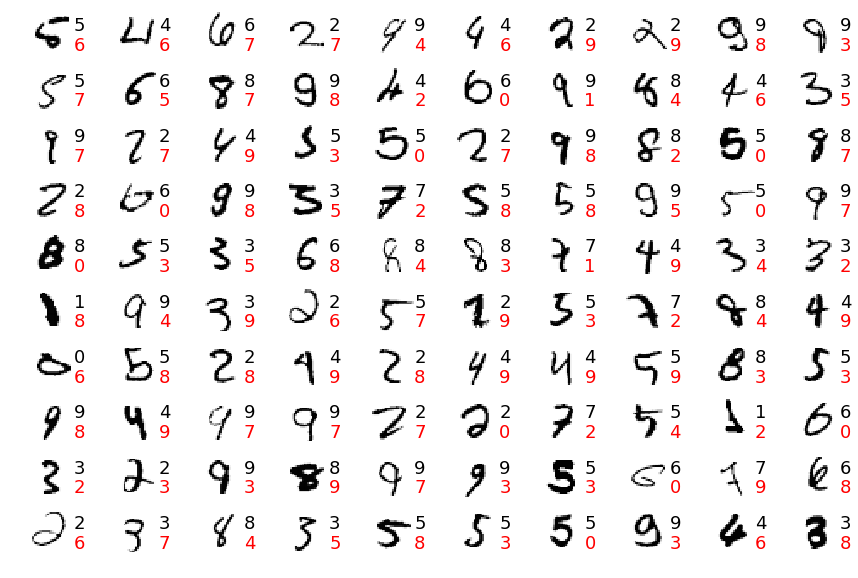

In [62]:
n = 10
fig, ax = plt.subplots(n, n, sharex=True, sharey=True)
ax = ax.flatten()
fig.set_size_inches(15, 10)
ax_id = 0
i = 0
while ax_id < n*n :
    x = test_data[i][0]
    y = test_data[i][1]
    y_ = ann.predict(x)
    if y_ != y:
        show_pic(ax[ax_id],x, y_, int(y))
        ax_id = ax_id + 1
    i = i + 1
        